In [116]:
import Pkg; Pkg.add(["Plots" ,"IterativeSolvers", "LinearMaps", "IncompleteLU", "AlgebraicMultigrid"]);
import Logging; Logging.disable_logging(Logging.Info)

   Resolving package versions...
   Installed AlgebraicMultigrid ─ v0.5.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [2169fc97] + AlgebraicMultigrid v0.5.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [2169fc97] + AlgebraicMultigrid v0.5.1
Precompiling project...
  ✓ AlgebraicMultigrid
  1 dependency successfully precompiled in 2 seconds (306 already precompiled)


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [117]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false, fmt=:png);
using Printf;
using Interact;
using SparseArrays;
using IterativeSolvers;
using LinearMaps;
using IncompleteLU;
using AlgebraicMultigrid;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

**(follow along: <https://tinyurl.com/gtcse6643lec27>)**

# Preconditioning

**1. Review of Krylov convergence results**

**2. Preconditioner theory**

**3. Preconditioners: left, right, and symmetric**

**4. Types of preconditioners**

## Review of Krylov convergence results

### GMRES

$$\large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \|b - Ax\|_2$$

$$\large r_n = b - A x_n$$

$$\large A = X \Lambda X^{-1}$$

$$\large \|r_{n+1}\|_2 \leq \|r_{n}\|_2$$

$$\large\frac{\|r_n\|_2}{\|\underbrace{r_0}_{b}\|_2} \leq \kappa(X) \min_{p_n \in P_n} \max_{\lambda \in \Lambda} |p_n(\lambda)|$$

![](./ellipse.svg)

![](./ellipse2.svg)

$$\large\frac{\|r_n\|_2}{\|r_0\|_2} \lesssim \kappa(X) \left(\frac{a + \sqrt{a^2 - d^2}}{c + \sqrt{c^2 - d^2}}\right)^n$$

### Extreme 1: $d = 0$ (ellipse is a circle)

![](./ellipse3.svg)

$$\large\frac{\|r_n\|_2}{\|r_0\|_2} \lesssim \kappa(X) \left(\frac{a}{c}\right)^n$$

Ratio of radius of smallest circle containing eigenvalues to distance of the circle's midpoint from the origin

### Extreme 2: $d = a$ (ellipse is a line)

![](./ellipse4.svg)

$$\large\frac{\|r_n\|_2}{\|r_0\|_2} \lesssim \kappa(X) \left(\frac{a}{c - \sqrt{c^2 - a^2}}\right)^n =
\kappa(X)\left(\frac{\sqrt{\lambda_{\max}/\lambda_{\min}} - 1 }{\sqrt{\lambda_{\max}/\lambda_{\min}} + 1}\right)^n$$

### CG

$$\large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \|\underbrace{A^{-1}b}_{x^\star} - x\|_A$$

$$\large e_n = x_n - x^\star$$

$$\large A = A^*, \quad A \succ 0$$

$$\large\frac{\|e_n\|_A}{\|\underbrace{e_0}_{A^{-1}b}\|_A}
\leq \min_{p_n \in P_n} \max_{\lambda \in \Lambda} |p_n(\lambda)|$$

### CG convergence bound

$$\large\frac{\|e_n\|_A}{\|e_0\|_A}
\leq 2 \left(\frac{\sqrt\kappa - 1}{\sqrt\kappa + 1}\right)^n$$

### Isolated eigenvalues

Isolated eigenvalues are well approximated by Ritz values quickly.  Once they have been well approximated, the convergence behavior is determined by the rest of the spectrum.

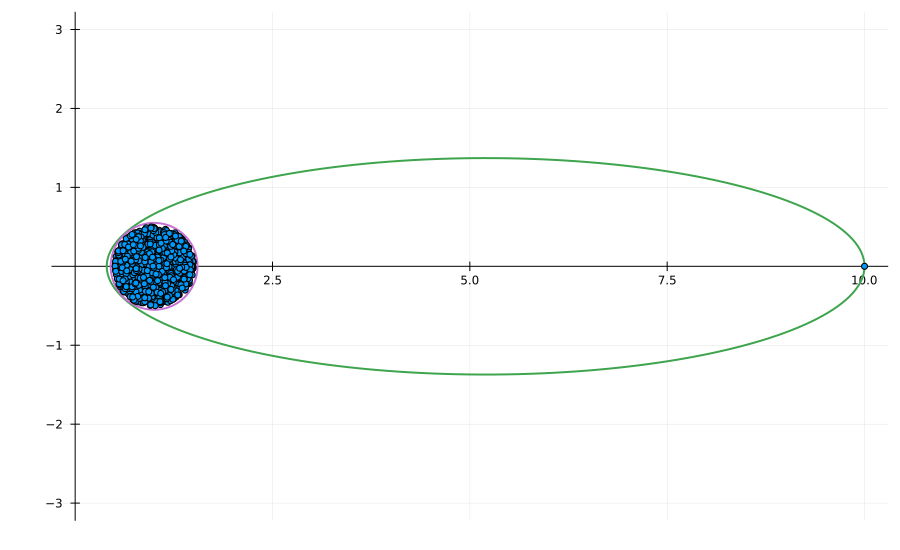

In [4]:
m = 1000
Λ = 1 .+ 0.5 * (rand(m) .^ 0.5) .* exp.((im * 2 * π) .* rand(m))
push!(Λ, Complex{Float64}(10))
θ = LinRange(0,2π,200)
c = 5.2
a = 10 - c
d = 4.6
b = sqrt(a^2 - d^2)
v = [c .+ a*cos.(θ) .+ im*sin.(θ)*b]
ρ₁ = (a + sqrt(a^2 - d^2))/(c + sqrt(c^2 - d^2))
ρ₂ = 0.5
#display("(a + sqrt(a^2 - d^2))/(c + sqrt(c^2 - d^2)))
p = plot(real.(v), imag.(v), c=3, l=2)
v = [1 .+ 0.55.*cos.(θ) .+ im*0.55*sin.(θ)]
plot!(p, real.(v), imag.(v), c=4, l=2)
plot!(real.(Λ), imag.(Λ), st=:scatter, framestyle=:origin, aspect_ratio=:equal, c=1)

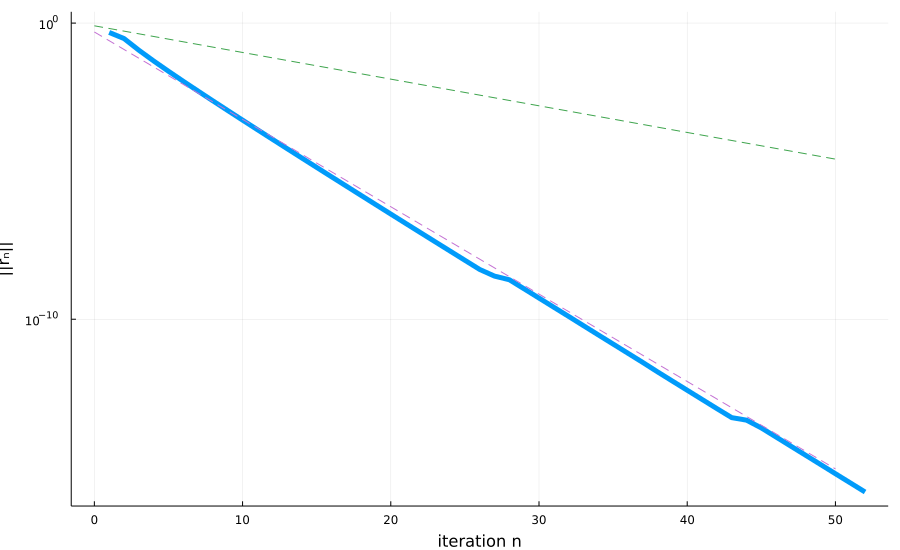

In [5]:
U = qr(randn(Complex{Float64},m+1,m+1)).Q;
A = U * Diagonal(Λ) * U';
b = randn(m+1)
hist= gmres(A, b; reltol=eps(), log=true)[2]
plot(hist[:resnorm] ./ norm(b),xlabel="iteration n", ylabel="||rₙ||", yscale=:log10)
plot!([0,50],[ρ₁,ρ₁^50], l=(:dash,1), c=3)
plot!([0,50],[ρ₂,ρ₂^50], l=(:dash,1), c=4)

### Repeated eigenvalues

Although our coarse convergence rates involve the hull of the spectrum, Krylov methods converge at iteration $n$ (in exact arithmetic) if the minimal polynomial as degree $n$

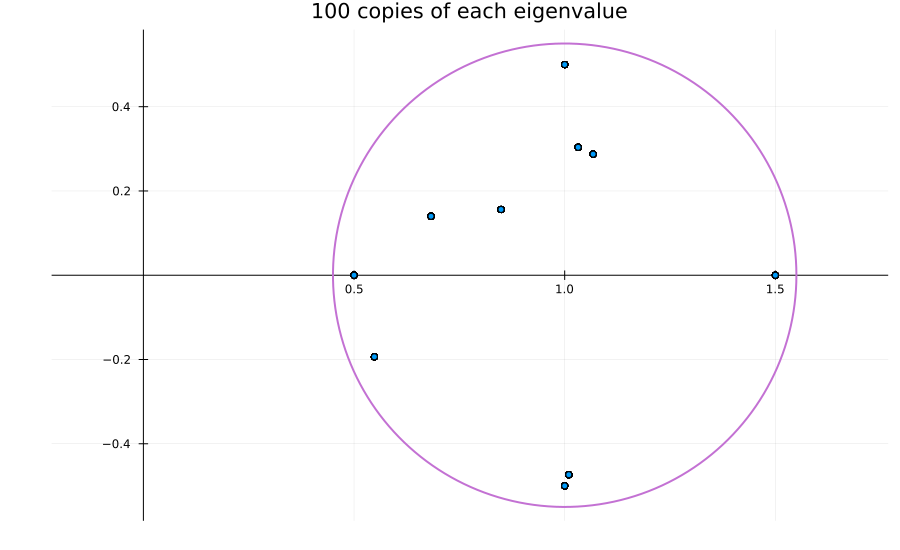

In [6]:
m = 1000
Λ = 1 .+ 0.5 * (rand(m) .^ 0.5) .* exp.((im * 2 * π) .* rand(m))
Λ[1] = 0.5
Λ[101] = 1.5
Λ[201] = 1 + 0.5*im
Λ[301] = 1 - 0.5*im
for i in 1:10
    Λ[100*(i-1)+2:100*i] .= Λ[100*(i-1)+1]
end
θ = LinRange(0,2π,200)
p = plot(real.(v), imag.(v), c=4, l=2)
plot!(p, real.(Λ), imag.(Λ), st=:scatter, framestyle=:origin, aspect_ratio=:equal, c=1, title = "100 copies of each eigenvalue")

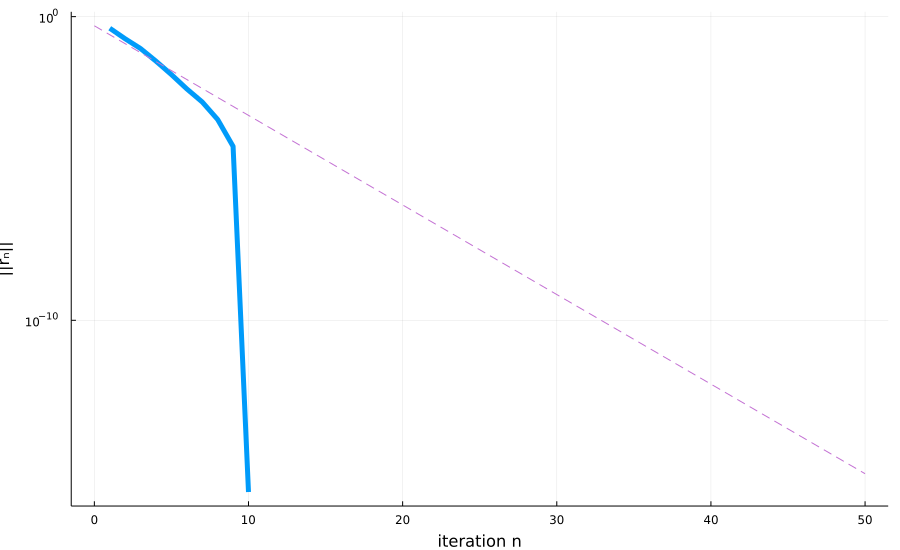

In [7]:
U = qr(randn(Complex{Float64},m,m)).Q;
A = U * Diagonal(Λ) * U';
b = randn(m)
hist= gmres(A, b; reltol=eps(), log=true)[2]
plot(hist[:resnorm] ./ norm(b),xlabel="iteration n", ylabel="||rₙ||", yscale=:log10)
plot!([0,50],[ρ₂,ρ₂^50], l=(:dash,1), c=4)

### There are other Krylov methods we haven't talked about

- **MINRES**
  - mathematically GMRES applied to hermitian matrices
  - short recurrence ($O(m)$ non-matvec work per iteration) like CG
- **Biorthogonalization methods** (BiCGStab, QMR)
  - methods for non-hermitian matrices that have short recurrences unlike GMRES
  - Not optimal in a natural norm like GMRES

### ... but in all cases they work best if

- Eigenvalues are **clustered away from the origin**

## Preconditioner theory

### Replace the original problem

$$\large A x = b$$

### With the preconditioned problem

$$\large M A x = M b$$

- $M$ is the **preconditioner**: must be nonsingular so the preconditioned problem has the same unique solution

- Where we needed $x \mapsto Ax$ matvecs, we now need $x \mapsto MA x$ matvecs

### $MA$ is the linear operator that appears in convergence proofs

$$ \large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(MA,Mb)} \|Mb - MA x\|_2 $$

$$ \min_{x \in \mathcal{K}_n(MA,Mb)} \|Mb - MA x\|_2\large \leq \kappa(X_{MA}) \min_{p_n\in P^n} \max_{\lambda \in \Lambda(MA)} |p_n(\lambda)|$$

- Ignoring $\kappa(X_{MA})$ for now, the goal is to pick $M$ to minimize

$$\large \min_{p_n\in P^n} \max_{\lambda \in \Lambda(MA)} |p_n(\lambda)|$$

### Begging the question

If $M = A^{-1}$, then  $MA = I$, and

$$ \large \large \min_{p_n\in P^n} \max_{\lambda \in \Lambda(MA)} |p_n(\lambda)| = 0 $$

Because $p_1(x) = (1 - x)$ is zero at the single eigenvalue $1$.

- But we are using an iterative method because $A^{-1}$ is expensive to compute and apply

### Tradeoff analysis

Suppose preconditioner has

- **Setup time** $T_{\text{setup}}(M)$

- **Application time** $T_{\text{apply}}(M)$

How much smaller does $\kappa(MA)$ have to be than $\kappa(A)$ for preconditioning to speed up the solution?

### Simple calculation

- Assume the time of CG is dominated by the matvec,

$$T_{\text{CG,iteration}} \approx T_{\text{matvec}}(A)$$

- Ignore preconditioner setup,

$$T_{\text{setup}}(M) = 0$$

- Normalize the matvec time,

$$T_{\text{matvec}}(A) = 1$$

- The time for $n$ iterations of preconditioned $CG$ is 

$$n (1 + T_{\text{apply}}(M))$$

- We approximate the **unpreconditioned** error at time $t$ as

$$E_A(t) = \left(\frac{\sqrt{\kappa(A)} - 1}{\sqrt{\kappa(A)} + 1}\right)^{t}$$

- We approximate the **preconditioned** error at time $t$ as

$$E_{MA}(t) = \left(\frac{\sqrt{\kappa(MA)} - 1}{\sqrt{\kappa(MA)} + 1}\right)^{t / (1 + T_{\text{apply}}(M))} = \left[\left(\frac{\sqrt{\kappa(MA)} - 1}{\sqrt{\kappa(MA)} + 1}\right)^{1 / (1 + T_{\text{apply}}(M))}\right]^t$$

- In this model **preconditioning is effective** if

$$\frac{\sqrt{\kappa(MA)} - 1}{\sqrt{\kappa(MA)} + 1}< \left(\frac{\sqrt{\kappa(A)} - 1}{\sqrt{\kappa(A)} + 1}\right)^{1 + T_{\text{apply}}(M)}$$

If $\sqrt{\kappa} \gg 1$, this requires

$$\large \kappa(MA) \lesssim \frac{\kappa(A)}{(1 + T)^2}$$

**Example:** If $T_{\text{apply}}(M) = T_{\text{matvec}}(A)$, then it should reduce the condition number by more than a factor of 4.

### Attention paid in this class $\neq$ importance

- In lectures, 3:1  Krylov:preconditioning

- In affect on iterative method performance, 1:5 Krylov:preconditioning

- Take CSE/MATH 6644 for more on preconditioning

## Preconditioners: left, right, and symmetric

### Left preconditioning (what we have already seen)

$$\large M A x = M b$$

1. Compute new right hand side $\tilde b = Mb$

2. Use iterative method with operator $MA$ and right hand side $\tilde b$ to compute $x$

### Right preconditioning

$$ \large A M \underbrace{(M^{-1} x)}_{\tilde{x}} = b$$

What algorithm is implied by this equation?

1. Use iterative method with operator $A M$ and right hand side $b$ to compute $\tilde x$

2. Compute the solution $x = M \tilde x$

### When should we use left or right preconditioning?

**Q.** Is there any difference between $\Lambda(AM)$ and $\Lambda(MA)$?

**A.**

$$AM \sim M (AM) M^{-1} = MA$$

So the polynomial minimization problem is the same, although the eigenbasis can differ: if $AM = X \Lambda X^{-1}$, then $MA = (MX) A (MX)^{-1}$ (this is subtle and hard to control).

### Stopping criteria

The **residual norm** of a **left-preconditioned problem is**

$$\large r_{\text{left},n} = Mb - MA x_n = M(b - A x_n) = M r_n,$$

so

$$\large \|r_{\text{left},n}\|_2 = \| M r_n \|_2 = \| r_n \|_{M^* M}.$$

**The norm used for a stopping criterion has changed.**  We call this the _preconditioned norm._

All finite-dimensional norms are equivalent ($\|r_n \|_{M^* M} \to 0$ at the same asymptotic rate as $\|r_n\|_2 \to 0$), but they can be very different when stopping after finite steps.

On the other hand,

$$\large r_{\text{right},n} = b - A M \tilde{x}_n,$$

So **right preconditioning does not affect** using $$\|r_{\text{right},n}\|_2$$ as a stopping criterion.

### Is it better to use the $\ell_2$-norm (right preconditioning) or the preconditioned norm (left preconditioning)?

Yes.

- Sometimes we need to guarantee $\ell_2$ is small (example: solving $Ax = b$ as part of _implicit time stepping_)

- Sometimes solutions $x_n$ and $r_n$ represent such different types of quantities that, even though they are both vectors in $\mathbb{C}^n$, it makes sense to **use different norms measure solutions and residuals**.  And sometimes the preconditioned norm is a good norm for residuals.

### Conundrum

1. CG requires the operator to be hermitian positive definite

2. $MA$ and $AM$ are not in general Hermitian

How do we precondition the conjugate gradient method?

### Option 1: symmetric preconditioning

Let $L$ be such that $L L^* \approx A^{-1}$

$$\large A x = b$$

$$\large \underbrace{L A L^*}_{\text{h.p.d.}} \underbrace{L^{-*} x}_{\tilde x} = L b$$

**Q.** What is the implied algorithm?

1. Compute $\tilde b = L b$

2. Apply the conjugate gradient method with operator $(LAL^*)$ and rhs $\tilde b$ to get $\tilde x$

3. Compute $x = L^* b$

### Option 2: norm preconditioning (or just the Preconditioned Conjugate Gradient (PCG) method)

1. Treat solution vectors ($x_n$, $p_n$) and residual vectors ($b$, $Ap$, $r$) as belonging to **different vector spaces**: pretend they cannot be added ($p_{n+1} \gets r_n + \beta_n p_n$ does not compute)

2. The solution and residual space are **dual:** dot products only work if one vector is a solution vector and the other vector is a residual vector ($r_n^* r_n$ does not compute)

3. $A: x \mapsto Ax$ turns solution vectors into residual vectors.  **Let $M$ be an h.p.d.** operator that turns
residuals into solutions, $M:r \mapsto Mr$

### Activity: derive PCG

Apply these rules to turn CG into PCG

1. Treat solution vectors ($x_n$, $p_n$) and residual vectors ($b$, $Ap$, $r$) as belonging to **different vector spaces**: pretend they cannot be added ($p_{n+1} \gets r_n + \beta_n p_n$ does not compute)

2. The solution and residual space are **dual:** dot products only work if one vector is a solution vector and the other vector is a residual vector ($r_n^* r_n$ does not compute)

3. $A: x \mapsto Ax$ turns solution vectors into residual vectors.  **Let $M$ be an h.p.d.** operator that turns
residuals into solutions, $M:r \mapsto Mr$

_Hint:_ you can apply $M$ once per iteration and save the result (like we do with $s_k \gets A p_k$)

$x_0 \gets 0$, $r_0 \gets b$, $p_0 \gets r_0$, $k \gets 0$

1. $\alpha_k \gets \frac{r_{k}^* r_k}{p_k^* \underbrace{(A p_k)}_{s_k}}$
2. $x_{k+1} \gets x_k + \alpha_k p_k$
3. $r_{k+1} \gets r_k - \alpha_k \underbrace{(A p_k)}_{s_k}$
4. $\beta_k \gets \frac{r_{k+1}^* r_{k+1}}{r_k^* r_k}$
5. $p_{k+1} \gets r_k + \beta_k p_k$
5. $k \gets k+1$

## Types of preconditioners

### Matrix decomposition

$A$ requires $O(m^3)$ operations to invert.  Let $M$ be a subset of entries of $A$ that can be inverted faster

1. $M = \mathrm{diag}(A)^{-1}$: **Jacobi preconditioning**

   - $r \mapsto M r$ uses $O(m)$ work and $O(m)$ memory movement: typically $T_{\text{apply}}(M) \ll T_{\text{matvec}}(A)$
   
   - Not very good on its own: $x_{k+1} \gets M r_k$ only converges for special matrices

2. $M = \mathrm{triu}(A)^{-1}$ or $M = \mathrm{tril}(A)^{-1}$: **Gauss-Seidel preconditioning**

   - $r \mapsto M r$ uses $O(nnz)$ work and $O(nnz)$ memory movement: typically $T_{\text{apply}}(M) < T_{\text{matvec}}(A)$ (but not always because GS does is not inherently parallel)
   - Converges on its own more than Jacobi: $x_{k+1} \gets M r_k$ converges if $A$ is h.p.d.

### Numerical experiment

In [8]:
function laplacian(d, m)
    if d == 1
        return SparseMatrixCSC(SymTridiagonal(2 * ones(m), -1 * ones(m-1)))
    elseif d > 1
        L₁ = laplacian(1, m)
        L = laplacian(d-1,m)
        Id = SparseMatrixCSC(Diagonal(ones(m^(d-1))))
        I₁ = SparseMatrixCSC(Diagonal(ones(m)))
        return SparseMatrixCSC(kron(L,I₁)) + SparseMatrixCSC(kron(Id, L₁))
    end
end;

In [74]:

function LinearAlgebra.ldiv!(A::SparseMatrixCSC{Float64, Int64}, V::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true})
    w = A \ V[:,]
    #display(A)
    #display(norm(A * w - V[:,]))
    V[:,] = w
    return V
end

function LinearAlgebra.ldiv!(A::SparseMatrixCSC{Float64, Int64}, v::Vector{Float64})
    
    w = A \ v
    #display(norm(A * w - v))
    v[:] = w
    return v
end

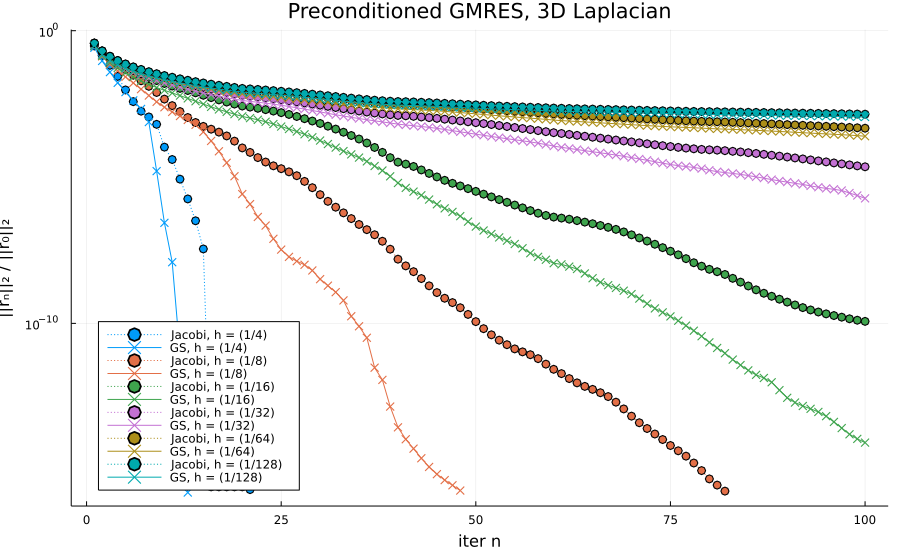

In [90]:
p = plot(xlabel = "iter n", ylabel = "||rₙ||₂ / ||r₀||₂", yscale=:log10, title="Preconditioned GMRES, 3D Laplacian", legend=:bottomleft)
for (i,m) in enumerate([4, 8, 16, 32, 64, 128])
    A = laplacian(3, m)
    MJ = Diagonal(diag(A))
    MGS = triu(A)
    b = randn(size(A)[1])
    x_j, hist_j = gmres(A, b; reltol=eps(), Pr=MJ, maxiter=100, log=true)
    x_gs, hist_gs = gmres(A, b; reltol=eps(), Pr=MGS, maxiter=100, log=true)
    plot!(p, hist_j[:resnorm] ./ norm(b), l=(:dot,1), m=:o, c=i, label="Jacobi, h = (1/$m)")
    plot!(p, hist_gs[:resnorm] ./ norm(b), l=1, m=:x, c=i, label="GS, h = (1/$m)")
end
p

- Preconditioning with Gauss-Seidel improves convergence, but the number of iterations required for convergence still depends on the problem size (ideally number of iterations is $O(1)$, independent of problem size)

### Incomplete factorization

- True factorizations have lots of **fill in** (nonzeros where $A$ has zeros)

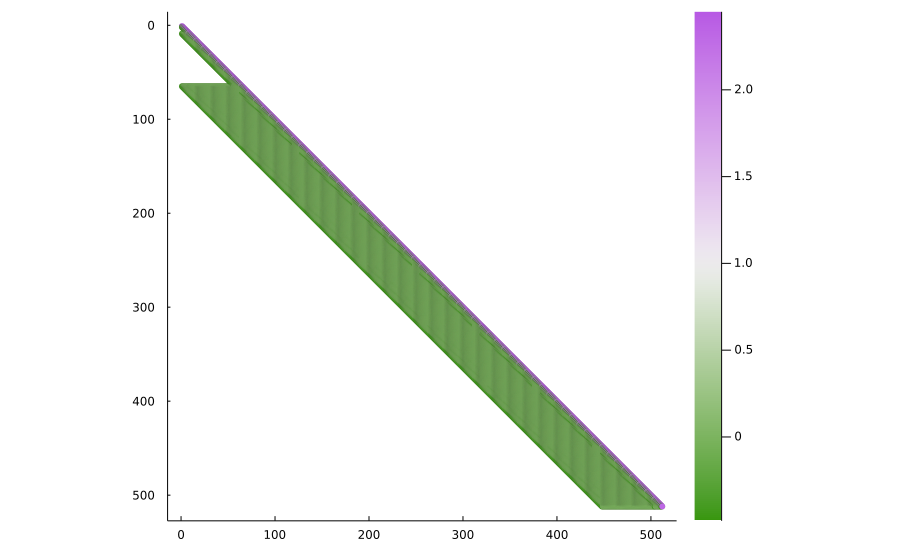

In [92]:
L = cholesky(Matrix(laplacian(3,8))).L
bigspy(L)

- Compute an approximate factorization where entries are dropped from $L$ to keep it sparse:
  - Drop all entries not in $A$: ILU(0)
  - Drop entries smaller than a tolerance $\tau$: ILU($\tau$)
  - Balancing matrix size, efficiency, factorization error: requires expertise
    - Libraries that provide sparse direct solvers (SuiteSparse, SuperLU, MUMPS, etc.), usually also provide incomplete factorizations

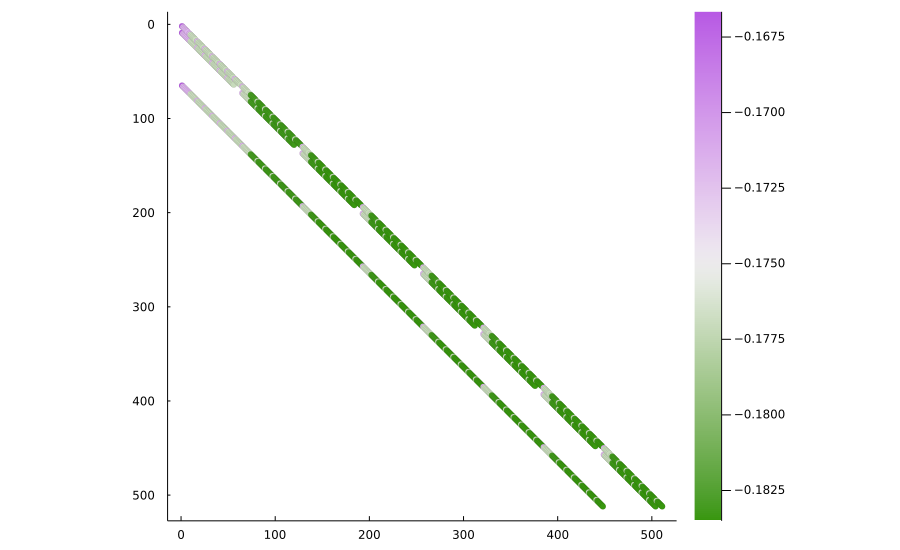

In [111]:
ic = ilu(laplacian(3,8), τ=1)
bigspy(ic.L)

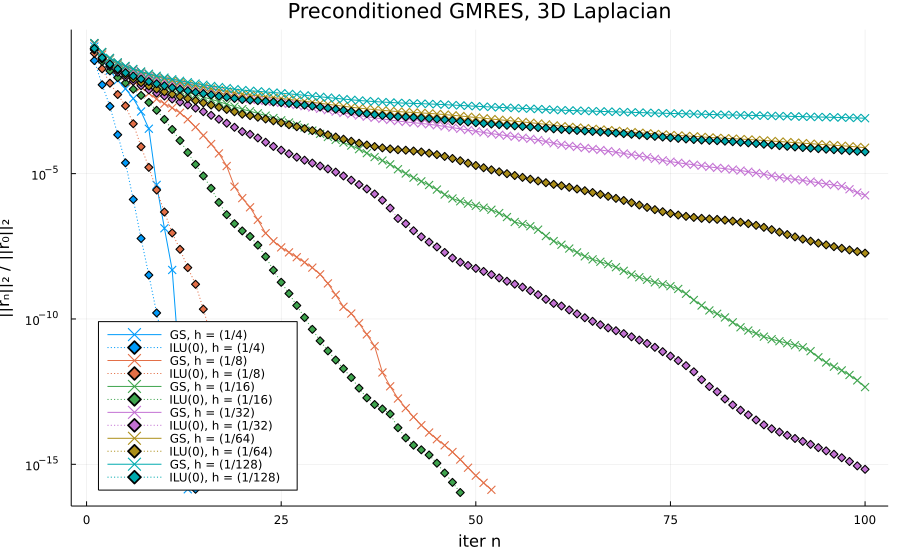

In [114]:
p = plot(xlabel = "iter n", ylabel = "||rₙ||₂ / ||r₀||₂", yscale=:log10, title="Preconditioned GMRES, 3D Laplacian", legend=:bottomleft)
for (i,m) in enumerate([4, 8, 16, 32, 64, 128])
    A = laplacian(3, m)
    MGS = triu(A)
    ic = ilu(A, τ=1.0)
    L = SparseMatrixCSC(ic.L + I)
    U = SparseMatrixCSC(ic.U')
    b = randn(size(A)[1])
    x_gs, hist_gs = gmres(A, b; reltol=eps(), Pr=MGS, maxiter=100, log=true)
    x_ilu, hist_ilu = gmres(A, b; reltol=eps(), Pl=L, Pr=U, maxiter=100, log=true)
    plot!(p, hist_gs[:resnorm] ./ norm(b), l=1, m=:x, c=i, label="GS, h = (1/$m)")
    plot!(p, hist_ilu[:resnorm] ./ norm(b), l=(:dot,1), m=:diamond, c=i, label="ILU(0), h = (1/$m)")
end
p

- Convergence rates are better than GS, but still not independent of problem size

### Domain decomposition

Basic geometric idea: solve subproblems independently and combine the solutions

![](./dpw_near_grid.png)

(Beth Lee-Rausch, NASA Langley)

Geometric idea has an algebraic interpretation: problem on subdomains $\sim$ collection of projections of the original problem: **additive Schwarz method**

$$ x \gets \sum_{j} R_j(\underbrace{R_j^* A R_j}_{\text{projected subproblem}})^{-1} R_j^* b $$

- If the subdomain problems are solved exactly, the convergence of the preconditioned subproblem is determined by

$$\large \frac{\text{min. subdomain size}}{\text{domain size}}$$

- Convergence still gets worse if this ratio $\to 0$

### Multigrid preconditioners

Problems like the Laplacian problem are called _elliptic_.

Jacobi, Gauss-Seidel, ILU, and basic domain decomposition are _local preconditioners_:

- If $M e_j$ is a sparse vector with nonzeros "close" to the entry at index $j$, the preconditioner is local

All local preconditioners have convergence that gets worse for elliptic problems as the problem size gets bigger 

- Correct the deficiencies of local preconditioners with a solution from a **coarser grid** representation of the same problem

![](./multigrid_sohpc.png)

### Multigrid V-cycle

1. Use a cheap local preconditioner, a _smoother_,

$$x_{\text{pre}} \gets x_0 + M_{\text{pre}}(b - A x_0)$$

2. $M_{\text{pre}}$ would not be good at reducing $r_{\text{pre}} = b - A x_{\text{pre}}$ anymore, so _restrict_ it to a _coarse grid_,

$$r_{\text{coarse}} \gets R r_{\text{pre}}.$$

3. Solve for the _coarse correction_,

$$d_{\text{coarse}} \gets A_{\text{coarse}}^{-1} r_{\text{coarse}}.$$

Often $A_{\text{coarse}}$ is a restriction of $A$,

$$A_{\text{coarse}} = R^* A R.$$

4. _Prolong_ the coarse correction back to the original problem size and add it to solution,

$$x_{\text{post}} \gets x_{\text{pre}} + \underbrace{R^* d_{\text{coarse}}}_{d_{\text{fine}}}.$$

5. _Smooth_ errors introduced be the coarse correction,

$$x_1 \gets x_{\text{post}} + M_{\text{post}}(b - A x_{\text{post}}).$$

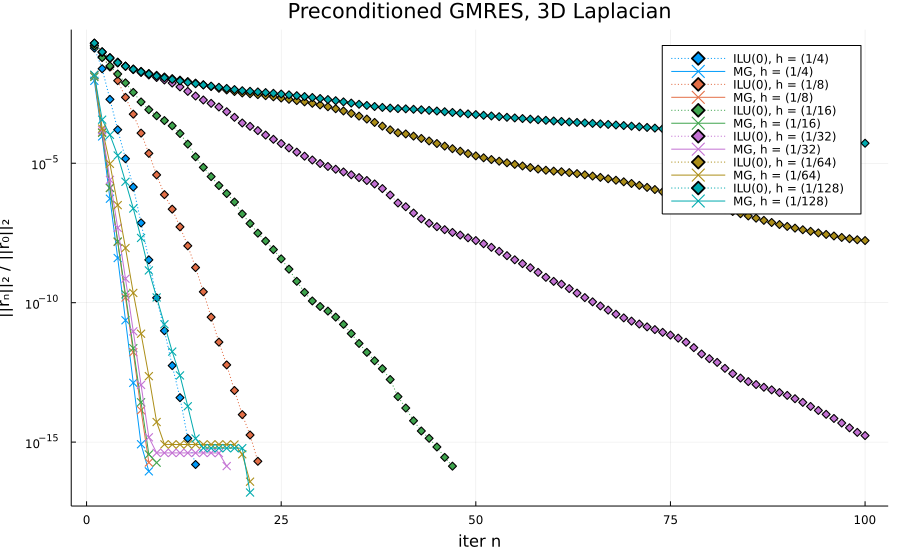

In [120]:
p = plot(xlabel = "iter n", ylabel = "||rₙ||₂ / ||r₀||₂", yscale=:log10, title="Preconditioned GMRES, 3D Laplacian", legend=:topright)
for (i,m) in enumerate([4, 8, 16, 32, 64, 128])
    A = laplacian(3, m)
    ic = ilu(A, τ=1.0)
    L = SparseMatrixCSC(ic.L + I)
    U = SparseMatrixCSC(ic.U')
    b = randn(size(A)[1])
    x_ilu, hist_ilu = gmres(A, b; reltol=eps(), Pl=L, Pr=U, maxiter=100, log=true)
    G = aspreconditioner(ruge_stuben(A))
    x_mg, hist_mg = gmres(A, b; reltol=eps(), Pr=G, maxiter=100, log=true)
    plot!(p, hist_ilu[:resnorm] ./ norm(b), l=(:dot,1), m=:diamond, c=i, label="ILU(0), h = (1/$m)")
    plot!(p, hist_mg[:resnorm] ./ norm(b), l=1, m=:x, c=i, label="MG, h = (1/$m)")
end
p

- Well-designed multigrid preconditioners are (or can get close to) **converge independent of problem size**

- There is a tradeoff because multigrid preconditioners can have significant $T_{\text{setup}}(M)$

### Subblock preconditioners

$F = \begin{bmatrix} A & B \\ C & D \end{bmatrix},$ assuming $F$ and $A$ are invertible, can be preconditioned with $M_A \approx A^{-1}$ and $M_S \approx (D - CA^{-1}B)^{-1})$

1. $\begin{bmatrix} M_A & \\ & M_S \end{bmatrix}$ (block triangular)

2. $\begin{bmatrix} M_A & \\ & I \end{bmatrix} \begin{bmatrix} I & -B \\ & I \end{bmatrix} \begin{bmatrix} I & \\ & M_S \end{bmatrix}$ (block upper triangular)

3. $\begin{bmatrix} I & \\ & M_S \end{bmatrix} \begin{bmatrix} I &  \\ -C & I \end{bmatrix} \begin{bmatrix} M_A & \\ & I \end{bmatrix} $ (block lower triangular)

4. full block inverse

### The algebra of preconditioner composition

Any place $X^{-1}$ appears one of the preconditioners is a chance to use another preconditioner.  For example:

- Use a preconditioner to solve the local subproblem in domain decomposition

- Use further multigrid preconditioning (use a _hierarchy_ of grids) as the coarse grid solver in multigrid

- Use a few iterations of a Krylov subspace method as a smoother for multigrid

- Use multigrid as a subblock preconditioner

- ...